In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
df2 = pd.read_excel('Main Data.xlsx')
original = df2.copy()

In [3]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1189 entries, 0 to 1188
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Gender                           1189 non-null   object 
 1   Branch                           1189 non-null   object 
 2   10th Percentage                  1189 non-null   float64
 3   10th Year of Passing             1189 non-null   int64  
 4   12th Or Diploma                  1189 non-null   object 
 5   12th or Diploma Percentage       1189 non-null   float64
 6   12th or Diploma Year of Passing  1189 non-null   int64  
 7   BE CGPI                          1189 non-null   float64
 8   Offers                           1189 non-null   object 
 9   Package                          1189 non-null   float64
 10  Year Of Placement                1189 non-null   int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 102.3+ KB


In [4]:
df2.describe

<bound method NDFrame.describe of       Gender                                Branch  10th Percentage  \
0       Male                  Computer Engineering             79.8   
1       Male                Information Technology             78.2   
2       Male  Computer Science and Business System             91.8   
3     Female  Computer Science and Business System             79.2   
4       Male                Information Technology             88.0   
...      ...                                   ...              ...   
1184    Male           Instrumentation Engineering             68.2   
1185    Male           Instrumentation Engineering             76.4   
1186    Male           Instrumentation Engineering             88.4   
1187    Male           Instrumentation Engineering             85.0   
1188    Male           Instrumentation Engineering             94.0   

      10th Year of Passing 12th Or Diploma  12th or Diploma Percentage  \
0                     2018            1

**encoding**

In [5]:
# One-hot encode categorical features
df2 = pd.get_dummies(df2, columns=['Gender', 'Branch', '12th Or Diploma'], drop_first=True)


**feature transformation**

In [6]:
# Creating interaction terms
df2['10th_12th_Interaction'] = df2['10th Percentage'] * df2['12th or Diploma Percentage']
df2['10th_BE_Interaction'] = df2['10th Percentage'] * df2['BE CGPI']
df2['12th_BE_Interaction'] = df2['12th or Diploma Percentage'] * df2['BE CGPI']


In [7]:
# Polynomial terms for 10th Percentage, 12th or Diploma Percentage, and BE CGPI
df2['10th_Percentage_Squared'] = df2['10th Percentage'] ** 2
df2['12th_Percentage_Squared'] = df2['12th or Diploma Percentage'] ** 2
df2['BE_CGPI_Squared'] = df2['BE CGPI'] ** 2


In [8]:
print(df2.columns)


Index(['10th Percentage', '10th Year of Passing', '12th or Diploma Percentage',
       '12th or Diploma Year of Passing', 'BE CGPI', 'Offers', 'Package',
       'Year Of Placement ', 'Gender_Male',
       'Branch_Computer Science and Business System',
       'Branch_Electronics Engineering',
       'Branch_Electronics and Telecommunication Engineering',
       'Branch_Information Technology', 'Branch_Instrumentation Engineering',
       '12th Or Diploma_Diploma', '10th_12th_Interaction',
       '10th_BE_Interaction', '12th_BE_Interaction', '10th_Percentage_Squared',
       '12th_Percentage_Squared', 'BE_CGPI_Squared'],
      dtype='object')


In [9]:
# Create a list of one-hot encoded branch columns
branch_columns = [col for col in df2.columns if col.startswith('Branch_')]
gender_column = 'Gender_Male'  # Assuming gender is encoded as 'Gender_Male' where Male=1, Female=0

# Calculate median package for each branch and gender combination
medians = df2.groupby(branch_columns + [gender_column])['Package'].median().reset_index()
medians = medians.rename(columns={'Package': 'Branch_Gender_Median_Package'})

# Merge this median data back into the main DataFrame
df2 = df2.merge(medians, on=branch_columns + [gender_column], how='left')


In [10]:
print(df2.columns)


Index(['10th Percentage', '10th Year of Passing', '12th or Diploma Percentage',
       '12th or Diploma Year of Passing', 'BE CGPI', 'Offers', 'Package',
       'Year Of Placement ', 'Gender_Male',
       'Branch_Computer Science and Business System',
       'Branch_Electronics Engineering',
       'Branch_Electronics and Telecommunication Engineering',
       'Branch_Information Technology', 'Branch_Instrumentation Engineering',
       '12th Or Diploma_Diploma', '10th_12th_Interaction',
       '10th_BE_Interaction', '12th_BE_Interaction', '10th_Percentage_Squared',
       '12th_Percentage_Squared', 'BE_CGPI_Squared',
       'Branch_Gender_Median_Package'],
      dtype='object')


In [11]:
# Quantile-based CGPI ranks
df2['CGPI_Rank'] = pd.qcut(df2['BE CGPI'], q=3, labels=['Low', 'Medium', 'High'])


In [12]:
# Check correlation by calculating average package for each CGPI rank
cgpi_package_correlation = df2.groupby('CGPI_Rank')['Package'].mean()
print(cgpi_package_correlation)


CGPI_Rank
Low       4.770655
Medium    4.893643
High      5.304391
Name: Package, dtype: float64


In [13]:
df2 = pd.get_dummies(df2, columns=['CGPI_Rank'], drop_first=True)

In [14]:
# Get CGPI_Rank, Branch, and Gender columns for interaction
cgpi_rank_columns = [col for col in df2.columns if col.startswith('CGPI_Rank')]
branch_columns = [col for col in df2.columns if col.startswith('Branch')]
gender_column = 'Gender_Male'  # Assuming gender is encoded as 'Gender_Male' where Male=1, Female=0

# Create interaction features between CGPI_Rank and Branch
for rank in cgpi_rank_columns:
    for branch in branch_columns:
        df2[f'{rank}_x_{branch}'] = df2[rank] * df2[branch]

# Create interaction features between CGPI_Rank and Gender
for rank in cgpi_rank_columns:
    df2[f'{rank}_x_Gender'] = df2[rank] * df2[gender_column]


In [15]:
print(df2.columns)

Index(['10th Percentage', '10th Year of Passing', '12th or Diploma Percentage',
       '12th or Diploma Year of Passing', 'BE CGPI', 'Offers', 'Package',
       'Year Of Placement ', 'Gender_Male',
       'Branch_Computer Science and Business System',
       'Branch_Electronics Engineering',
       'Branch_Electronics and Telecommunication Engineering',
       'Branch_Information Technology', 'Branch_Instrumentation Engineering',
       '12th Or Diploma_Diploma', '10th_12th_Interaction',
       '10th_BE_Interaction', '12th_BE_Interaction', '10th_Percentage_Squared',
       '12th_Percentage_Squared', 'BE_CGPI_Squared',
       'Branch_Gender_Median_Package', 'CGPI_Rank_Medium', 'CGPI_Rank_High',
       'CGPI_Rank_Medium_x_Branch_Computer Science and Business System',
       'CGPI_Rank_Medium_x_Branch_Electronics Engineering',
       'CGPI_Rank_Medium_x_Branch_Electronics and Telecommunication Engineering',
       'CGPI_Rank_Medium_x_Branch_Information Technology',
       'CGPI_Rank_Mediu

In [16]:
# Define target variable
y = df2['Package']

# Define feature variables by excluding 'Package' and 'Offers'
X = df2.drop(columns=['Package', 'Offers'])

# Check the first few rows to ensure the features and target are correct
X.head(), y.head()


(   10th Percentage  10th Year of Passing  12th or Diploma Percentage  \
 0             79.8                  2018                       68.92   
 1             78.2                  2018                       82.81   
 2             91.8                  2018                       76.62   
 3             79.2                  2018                       61.69   
 4             88.0                  2018                       68.75   
 
    12th or Diploma Year of Passing  BE CGPI  Year Of Placement   Gender_Male  \
 0                             2020     8.63                2024         True   
 1                             2021     7.50                2024         True   
 2                             2020     9.66                2024         True   
 3                             2020     8.30                2024        False   
 4                             2018     8.99                2024         True   
 
    Branch_Computer Science and Business System  \
 0                   

In [17]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the resulting datasets
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')


X_train shape: (951, 36)
X_test shape: (238, 36)
y_train shape: (951,)
y_test shape: (238,)


In [18]:
# Check for missing values
print(X_train.isnull().sum())
print(X_test.isnull().sum())


10th Percentage                                                            0
10th Year of Passing                                                       0
12th or Diploma Percentage                                                 0
12th or Diploma Year of Passing                                            0
BE CGPI                                                                    0
Year Of Placement                                                          0
Gender_Male                                                                0
Branch_Computer Science and Business System                                0
Branch_Electronics Engineering                                             0
Branch_Electronics and Telecommunication Engineering                       0
Branch_Information Technology                                              0
Branch_Instrumentation Engineering                                         0
12th Or Diploma_Diploma                                                    0

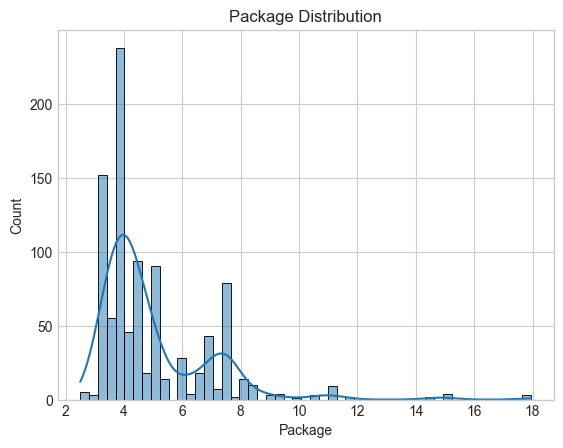

Skewness: 2.4567236341985734


In [19]:
# Plot distribution of the target variable
sns.histplot(y_train, kde=True)
plt.title('Package Distribution')
plt.show()

# Check skewness
print("Skewness:", y_train.skew())


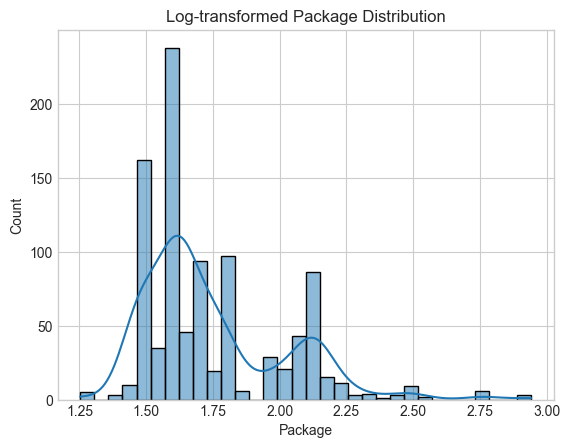

Skewness after transformation: 1.2466551282034102


In [20]:
# Apply log transformation to the target variable to reduce skewness
y_train_log = np.log1p(y_train)  # log1p is log(1 + x), which handles zero values well
y_test_log = np.log1p(y_test)

# Check the distribution again
sns.histplot(y_train_log, kde=True)
plt.title('Log-transformed Package Distribution')
plt.show()

# Check skewness after transformation
print("Skewness after transformation:", y_train_log.skew())


In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Initialize the model with the specified hyperparameters
model = RandomForestRegressor(
    max_depth=5, 
    min_samples_leaf=4, 
    min_samples_split=10, 
    n_estimators=200,
    random_state=42
)

# Train the model using the log-transformed target variable
model.fit(X_train, y_train_log)

# Make predictions on the test set
y_pred_log = model.predict(X_test)

# Inverse the log transformation for predictions and actual values
y_pred = np.expm1(y_pred_log)  # Inverse log transformation to original scale
y_test_orig = np.expm1(y_test_log)  # Inverse transformation for true values

# Evaluate the model's performance
mae = mean_absolute_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)

print(f'Mean Absolute Error (MAE) on original scale: {mae}')
print(f'R2 Score on original scale: {r2}')


Mean Absolute Error (MAE) on original scale: 1.2471899898562733
R2 Score on original scale: 0.02925129548194516


In [22]:
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score


In [23]:
# AdaBoost Model
adaboost = AdaBoostRegressor(learning_rate=0.01, n_estimators=50)

# XGBoost Model
xgboost = XGBRegressor(colsample_bytree=0.7, learning_rate=0.05, max_depth=3, 
                       min_child_weight=3, n_estimators=100, subsample=0.7)

# GradientBoosting Model
gbm = GradientBoostingRegressor(learning_rate=0.01, max_depth=3, min_samples_leaf=1, 
                                min_samples_split=2, n_estimators=100)

# RandomForest Model
random_forest = RandomForestRegressor(max_depth=5, min_samples_leaf=4, min_samples_split=10, 
                                      n_estimators=200)


In [24]:
# Initialize the Voting Regressor with the above models
voting_regressor = VotingRegressor(estimators=[
    ('adaboost', adaboost),
    ('xgboost', xgboost),
    ('gbm', gbm),
    ('random_forest', random_forest)
])
voting_regressor

VotingRegressor(estimators=[('adaboost', AdaBoostRegressor(learning_rate=0.01)),
                            ('xgboost',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.7, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importanc...
                                          max_delta_step=None, max_depth=3,
                                          max_leaves=None, min_child_weight=3,
                                          missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=100,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=None, ...)),
                            ('gbm',
                             GradientBoostingRegressor(learning_rate=0.01)),
                            ('random_forest',
                             RandomForestRegressor(max_depth=5,
                                                   min_samples_leaf=4,
                                                   min_samples_split=10,
                                                   n_estimators=200))])

In [25]:
# Fit the Voting Regressor
voting_regressor.fit(X_train, y_train)


VotingRegressor(estimators=[('adaboost', AdaBoostRegressor(learning_rate=0.01)),
                            ('xgboost',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.7, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importanc...
                                          max_delta_step=None, max_depth=3,
                                          max_leaves=None, min_child_weight=3,
                                          missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=100,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=None, ...)),
                            ('gbm',
                             GradientBoostingRegressor(learning_rate=0.01)),
                            ('random_forest',
                             RandomForestRegressor(max_depth=5,
                                                   min_samples_leaf=4,
                                                   min_samples_split=10,
                                                   n_estimators=200))])

In [26]:
# Make predictions on the test set
y_pred = voting_regressor.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")


Mean Absolute Error: 1.324961686103057
R² Score: 0.02178033022962056
